# **Using the Breast Cancer Wisconsin (Diagnostic) Database, we can create a classifier that can help diagnose patients and predict the likelihood of a breast cancer.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Important Feature using ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score



from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

# to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/Cancer.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


###Data visualisation and pre-processing

In [5]:
data.shape

(569, 33)

In [6]:
data.drop('Unnamed: 32',axis=1,inplace=True)

In [7]:
data.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

Number of Benign:  357

Number of Malignant :  212


In [8]:
data.drop('id',axis=1,inplace=True)

Number of Benign:  357
Number of Malignant :  212


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


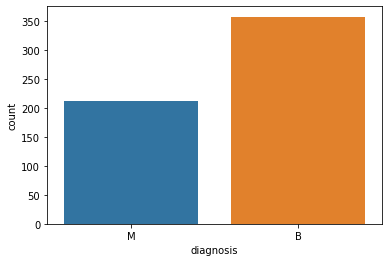

In [9]:
ax = sns.countplot(data['diagnosis'],label="Count")       # M = 212, B = 357
B, M = data.diagnosis.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

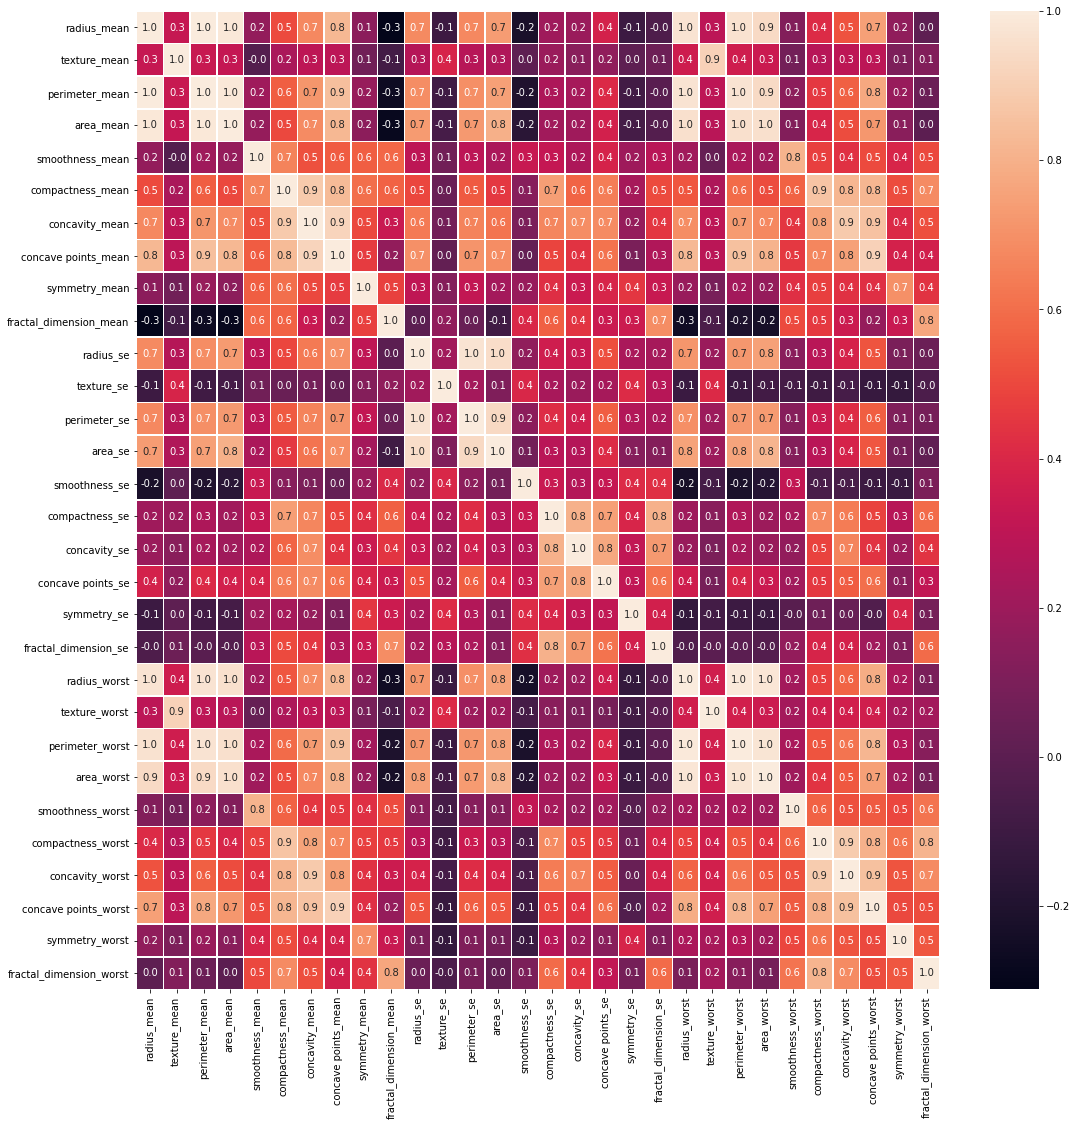

In [10]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [11]:
X = data.drop('diagnosis' ,axis=1)
y = data.diagnosis

In [12]:
X

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [13]:
y

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [14]:
y = y.replace(to_replace={'M':1,'B':0})

In [15]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

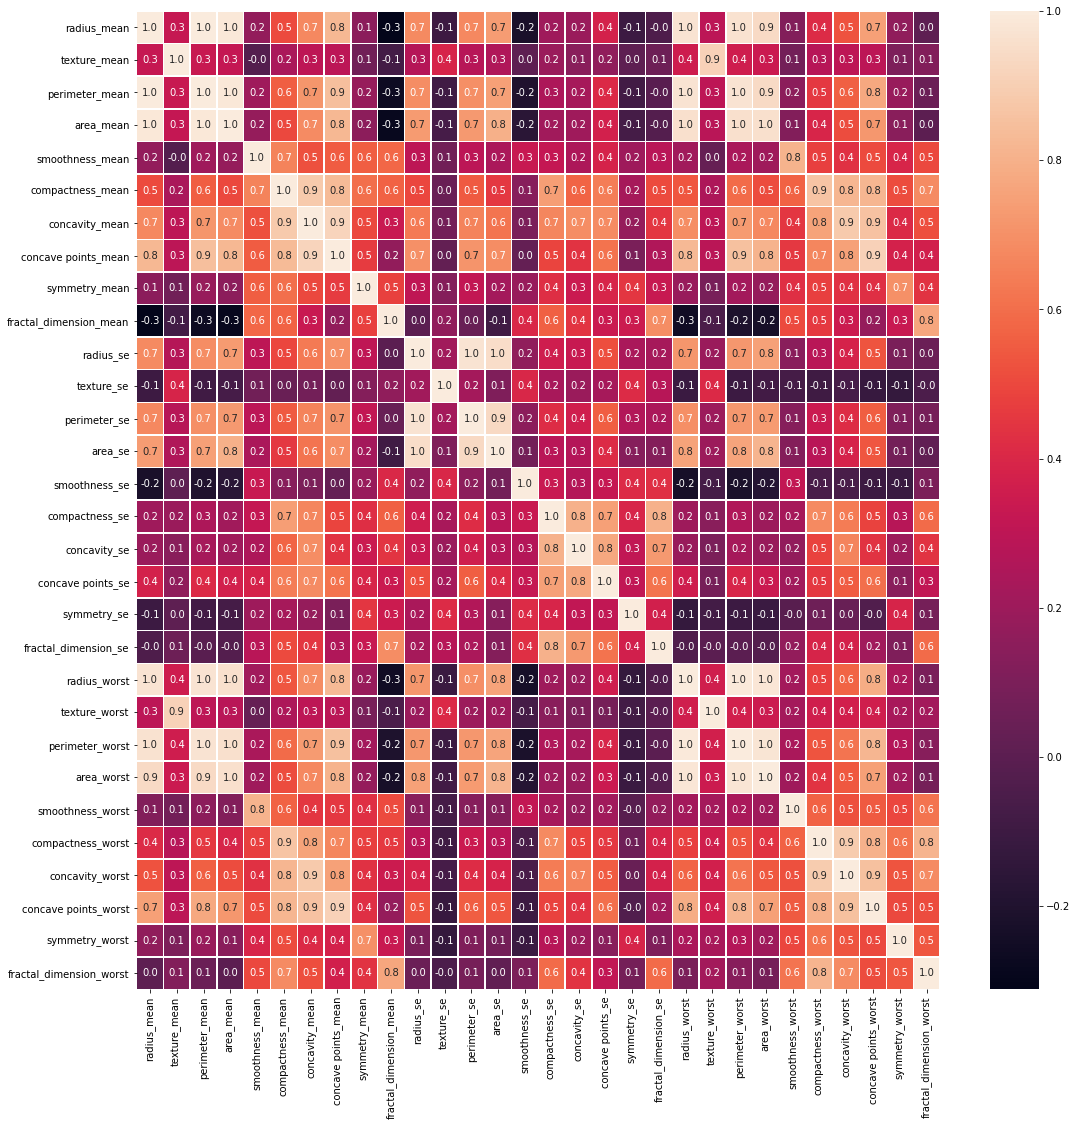

In [16]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

As it can be seen in map heat figure radius_mean, perimeter_mean and area_mean are correlated with each other so we will use only area_mean. If you ask how i choose **area_mean** as a feature to use, well actually there is no correct answer, I just look at swarm plots and **area_mean** looks like clear for me but we cannot make exact separation among other correlated features without trying. So lets find other correlated features and look accuracy with random forest classifier.

**Compactness_mean,** **concavity_mean** and **concave points_mean** are correlated with each other.

Therefore I only choose **concavity_mean**.

Apart from these, **radius_se**, **perimeter_se** and **area_se** are correlated and I only use **area_se**.

**radius_worst**, **perimeter_worst** and **area_worst** are correlated so I use **area_worst**.

**Compactness_worst**, **concavity_worst** and concave **points_worst** are correlated so I use **concavity_worst**.

**Compactness_se**, **concavity_se** and concave **points_se** are correlated so I use **concavity_se**.

**texture_mean** and **texture_worst** are correlated and I use **texture_mean**.

**area_worst** and **area_mean** are correlated, I use **area_mean**.

In [17]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concavity_mean','concave points_worst','compactness_se','concave points_se','texture_worst','area_worst']
x_1 = X.drop(drop_list1,axis = 1 )        # do not modify X, we will use it later 
x_1.head()

,texture_mean,area_mean,smoothness_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,10.38,1001.0,0.11840,0.2419,0.07871,0.9053,153.40,0.006399,0.05373,0.03003,0.006193,0.1622,0.7119,0.4601,0.11890
1,17.77,1326.0,0.08474,0.1812,0.05667,0.7339,74.08,0.005225,0.01860,0.01389,0.003532,0.1238,0.2416,0.2750,0.08902
2,21.25,1203.0,0.10960,0.2069,0.05999,0.7869,94.03,0.006150,0.03832,0.02250,0.004571,0.1444,0.4504,0.3613,0.08758
3,20.38,386.1,0.14250,0.2597,0.09744,1.1560,27.23,0.009110,0.05661,0.05963,0.009208,0.2098,0.6869,0.6638,0.17300
4,14.34,1297.0,0.10030,0.1809,0.05883,0.7813,94.44,0.011490,0.05688,0.01756,0.005115,0.1374,0.4000,0.2364,0.07678


In [18]:
x_1.shape

(569, 15)

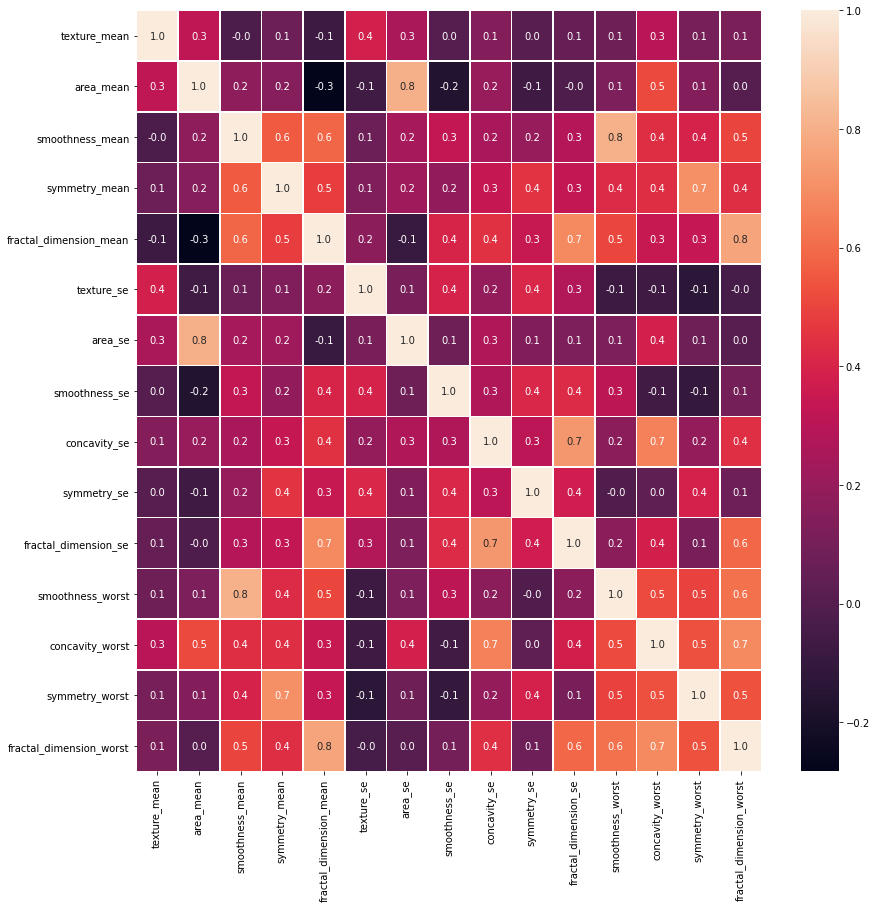

In [19]:
#correlation map
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(x_1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [20]:
selection = ExtraTreesRegressor()
selection.fit(x_1, y)


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

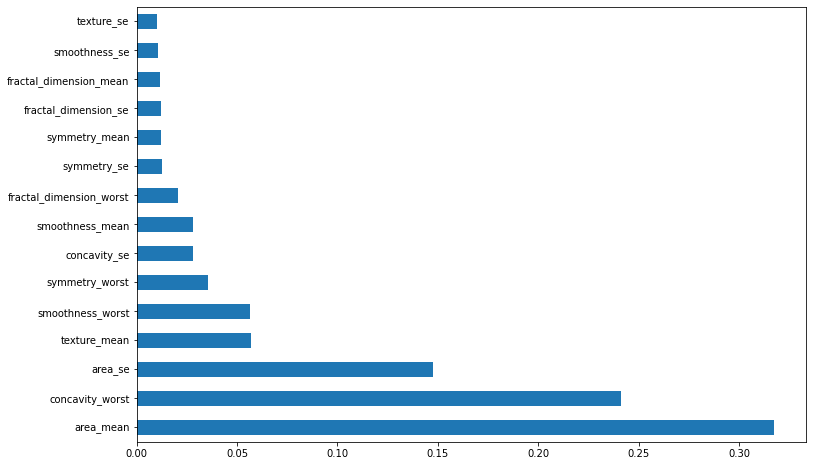

In [21]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=x_1.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [22]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x_1, y, test_size=0.3, random_state=42)


#Random Forest

Accuracy is:  0.9766081871345029
Accuracy is (Train) : 1.0


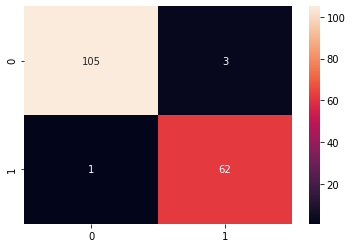

In [23]:
clf_rf = RandomForestClassifier(random_state=0)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
print("Accuracy is (Train) :", clr_rf.score(x_train,y_train))
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

#Logistic Regression

In [24]:
tuned_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']}
model = GridSearchCV(LogisticRegression(), tuned_params, scoring = 'roc_auc', n_jobs=-1)
model.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

Accuracy is (Test):  0.9766081871345029
Accuracy is (Train) : 0.9916174766178809


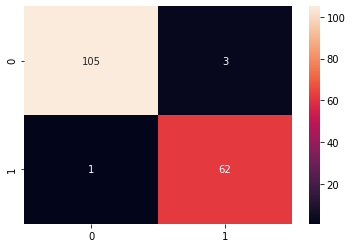

In [25]:
ac = accuracy_score(y_test,model.predict(x_test))
print('Accuracy is (Test): ',ac)
print("Accuracy is (Train) :", model.score(x_train,y_train))
cm = confusion_matrix(y_test,model.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

In [26]:
model.best_estimator_

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###Univariate feature selection and random forest classification
In this method we need to choose how many features we will use. For example, will k (number of features) be 5 or 10 or 15? The answer is only trying or intuitively. I do not try all combinations but I only choose k = 5 and find best 5 features.

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

Score list: [6.06916433e+01 3.66899557e+04 1.00015175e-01 1.95982847e-01
 3.42575072e-04 4.07131026e-02 6.12741067e+03 1.32470372e-03
 6.92896719e-01 1.39557806e-03 2.65927071e-03 2.63226314e-01
 2.58858117e+01 1.00635138e+00 1.23087347e-01]
Feature list: Index(['texture_mean', 'area_mean', 'smoothness_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'texture_se', 'area_se', 'smoothness_se',
       'concavity_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')


Accuracy is:  0.9532163742690059


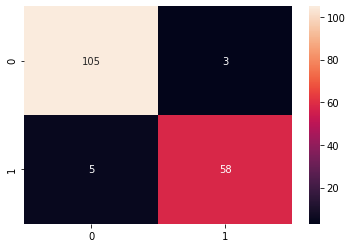

In [28]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)

ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

### Recursive feature elimination (RFE) with random forest

In [29]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train, y_train)
print('Chosen best 5 feature by rfe:',x_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['texture_mean', 'area_mean', 'area_se', 'concavity_worst',
       'symmetry_worst'],
      dtype='object')


In [30]:
x_2 = x_1.loc[:,['area_mean', 'area_se', 'smoothness_worst', 'concavity_worst',
       'symmetry_worst']]

In [31]:
x_2

,area_mean,area_se,smoothness_worst,concavity_worst,symmetry_worst
0,1001.0,153.40,0.16220,0.7119,0.4601
1,1326.0,74.08,0.12380,0.2416,0.2750
2,1203.0,94.03,0.14440,0.4504,0.3613
3,386.1,27.23,0.20980,0.6869,0.6638
4,1297.0,94.44,0.13740,0.4000,0.2364
...,...,...,...,...,...
564,1479.0,158.70,0.14100,0.4107,0.2060
565,1261.0,99.04,0.11660,0.3215,0.2572
566,858.1,48.55,0.11390,0.3403,0.2218
567,1265.0,86.22,0.16500,0.9387,0.4087


In [51]:
x_2.describe()

,area_mean,area_se,smoothness_worst,concavity_worst,symmetry_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000
mean,654.889104,40.337079,0.132369,0.272188,0.290076
std,351.914129,45.491006,0.022832,0.208624,0.061867
min,143.500000,6.802000,0.071170,0.000000,0.156500
25%,420.300000,17.850000,0.116600,0.114500,0.250400
50%,551.100000,24.530000,0.131300,0.226700,0.282200
75%,782.700000,45.190000,0.146000,0.382900,0.317900
max,2501.000000,542.200000,0.222600,1.252000,0.663800


In [32]:
# split data train 70 % and test 30 %
train_x, test_x, train_y, test_y = train_test_split(x_2, y, test_size=0.3, random_state=42)


In [33]:
train_x.shape

(398, 5)

#Random Forest

In [34]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model3= RandomizedSearchCV(RandomForestClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model3.fit(train_x,train_y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

Accuracy is (Test):  0.9649122807017544


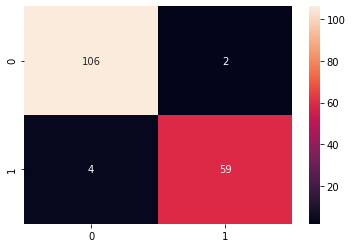

In [35]:
ac = accuracy_score(test_y,model3.predict(test_x))
print('Accuracy is (Test): ',ac)
cm = confusion_matrix(test_y,model3.predict(test_x))
sns.heatmap(cm,annot=True,fmt="d")

##Logistic Regresion

In [36]:
tuned_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']}
model = GridSearchCV(LogisticRegression(), tuned_params, scoring = 'roc_auc', n_jobs=-1)
model.fit(train_x,train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [37]:
model.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy is (Test):  0.9590643274853801


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


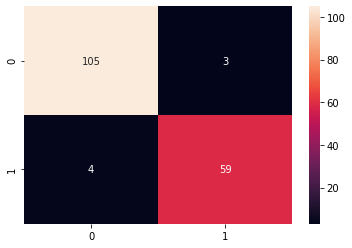

In [38]:
lr =LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

lr.fit(train_x,train_y)
ac = accuracy_score(test_y,lr.predict(test_x))
print('Accuracy is (Test): ',ac)
cm = confusion_matrix(test_y,lr.predict(test_x))
sns.heatmap(cm,annot=True,fmt="d")

In [39]:
print(classification_report(test_y ,lr.predict(test_x)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       108
           1       0.95      0.94      0.94        63

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



##XG

In [40]:
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(train_x,train_y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...ht=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated',

In [41]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Accuracy is (Test):  0.9473684210526315


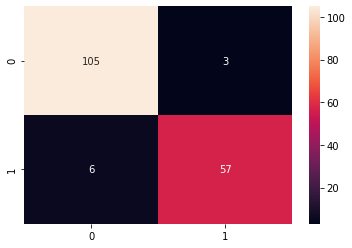

In [42]:
ac = accuracy_score(test_y,model.predict(test_x))
print('Accuracy is (Test): ',ac)
cm = confusion_matrix(test_y,model.predict(test_x))
sns.heatmap(cm,annot=True,fmt="d")

In [43]:
print(classification_report(test_y ,model.predict(test_x)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



#SVC

Accuracy on training set: 0.98
Accuracy is (Test):  0.6140350877192983


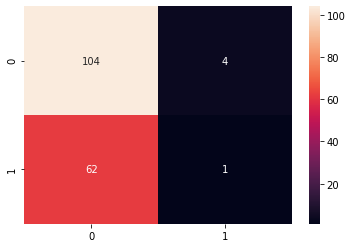

In [44]:
from sklearn.svm import SVC
svc = SVC( gamma = 'auto',random_state=12)
svc.fit(train_x, train_y)

print("Accuracy on training set: {:.2f}".format(svc.score(train_x, train_y)))
ac = accuracy_score(test_y,svc.predict(test_x))
print('Accuracy is (Test): ',ac)
cm = confusion_matrix(test_y,svc.predict(test_x))
sns.heatmap(cm,annot=True,fmt="d")

#Decision Tree

Accuracy on training set: 1.00
Accuracy is (Test):  0.935672514619883


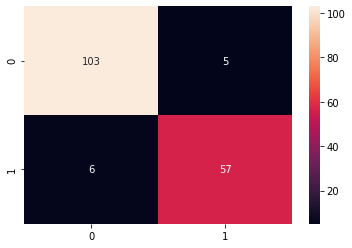

In [45]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=12)
DT.fit(train_x, train_y)

print("Accuracy on training set: {:.2f}".format(DT.score(train_x, train_y)))
ac = accuracy_score(test_y,DT.predict(test_x))
print('Accuracy is (Test): ',ac)
cm = confusion_matrix(test_y,DT.predict(test_x))
sns.heatmap(cm,annot=True,fmt="d")

#Save Model

Accuracy is (Test):  0.9590643274853801


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


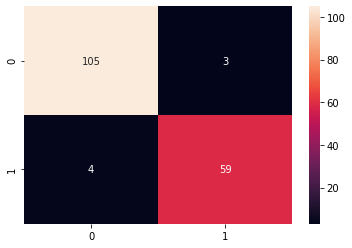

In [46]:
win_lr =LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

win_lr.fit(train_x,train_y)
ac = accuracy_score(test_y,win_lr.predict(test_x))
print('Accuracy is (Test): ',ac)
cm = confusion_matrix(test_y,win_lr.predict(test_x))
sns.heatmap(cm,annot=True,fmt="d")

In [47]:
import pickle
# Save the Modle to file in the current working directory

Pkl_Filename = "Health_care_Cancer_Predi.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(win_lr, file)

In [48]:
# Load the Model back from file
with open("Health_care_Cancer_Predi.pkl" , 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

In [49]:
y_pred = Pickled_LR_Model.predict([[1203.0,	94.03	,0.14440,	0.4504,	0.3613]])
y_pred

array([1])